## Posterior distribution has no Stdev

In [1]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from beartype.typing import Callable
from jaxtyping import Int

from p53_data import JAXP53_Data, dataset_3d, generate_test_times
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

key = jr.PRNGKey(42)

/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/gpjax_wp289/lib/python3.10/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
p53_data = JAXP53_Data(replicate=0)
training_times, gene_expressions, variances = dataset_3d(p53_data)

In [3]:
@dataclass
class latent_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = "p53 Cov"

    # Define parameters
    # BUG: crashes when using unconstrained parameters

    # Sensitivities of the genes
    initial_sensitivities = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)
    #initial_unconstrained_s = tfb.Softplus().inverse(initial_constrained_s)

    true_s: Float[Array, "1 5"] = param_field(
        initial_sensitivities,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_decays = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)
    #initial_unconstrained_d = tfb.Softplus().inverse(initial_constrained_d)

    true_d: Float[Array, "1 5"] = param_field(
        initial_decays,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_lengthscale = jnp.array(2.5, dtype=jnp.float64)
    #initial_unconstrained_l = l_bijector.inverse(initial_lengthscale)

    l: Float[Array, " O"] = param_field(
        initial_lengthscale, bijector=l_bijector, metadata={"name": "lengthscale"}
    )

    # Redefine parameters as static fields
    #true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))
    #l: Float[Array, " O"] = static_field(jnp.array(2.5))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t_prime, t)
        )

        return final_kernel

    def kernel_xx(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:
        """
        Equation 5 in paper k_xx(t,t')
        
        print('Input to kxx')
        print(f"t: {t}")
        print(f"t_prime: {t_prime}")
        """

        # Error trap (JAX friendly)
        def check_validity(condition):
            if condition:
                # raise ValueError("t or t' cannot be testing points (z=0)")
                return 0

        condition = jnp.logical_or(t[2] == 0, t_prime[2] == 0)
        jax.debug.callback(check_validity, condition)

        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()

    def kernel_xf(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:
        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = jnp.abs(gene_xpr - latent_force)

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        return kxf.squeeze()

    def kernel_ff(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:

        t = t[0] / self.l
        t_prime = t_prime[0] / self.l

        K = jnp.exp(-0.5 * squared_distance(t, t_prime))

        return K.squeeze()

    # Helper functions
    def h(
        self,
        j: Int[Array, " O"],
        k: Int[Array, " O"],
        t1: Float[Array, " O"],
        t2: Float[Array, " O"],
    ) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        # Debug print
        """
        print(f"j: {j}")
        print(f"k: {k}")
        print(f"t1: {t1}")
        print(f"t2: {t2}")
        """
        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        #print(f"result: {result}")
        return result

    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2


### Custom mean function

The mean function for the gene expressions per time is used to obtain the basal rates:

$$
f(x_{j}) = \frac{B_{j}}{D_{j}} 
$$

In [4]:
# Define custom mean
@dataclass
class latent_mean(gpx.mean_functions.AbstractMeanFunction):
    r"""
    Simple Input Motif mean function

    ```math
        f(x_{j}) = \frac{B_{j}}{D_{j}} 
    ```

    From equation 2 in paper.

    $B_{j}$ represents the basal rate for gene $j$ and is a trainable paramater.
    """

    # Pass kernel instance that contains true_d parameter
    kernel: gpx.kernels.AbstractKernel = field(default_factory=lambda: latent_kernel())
    
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64))
    
    # Define parameters
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True,)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        # BUG: Concretization error if this is used ?
        #num_genes = len(jnp.unique(x[:, 1]))
        num_genes = 5

        decays = self.kernel.true_d
        
        block_size = (x.shape[0] // num_genes)
        # Define the mean function
        #mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = (self.true_b / decays).reshape(1, -1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean



## GP regression

In [5]:
dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = generate_test_times()

In [6]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior, history

In [96]:
mean_function = latent_mean()
kernel = latent_kernel()

# Define the model
prior = gpx.gps.Prior(mean_function = mean_function, kernel = kernel, jitter=1e-4)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=dataset_train.n)
posterior = prior * likelihood

In [97]:
optimised_posterior, history = optimise_mll(posterior, dataset_train)

MLL before opt: 44.032
Optimization terminated successfully.
         Current function value: 4.615128
         Iterations: 56
         Function evaluations: 65
         Gradient evaluations: 65


In [98]:
from gpjax.base import meta_leaves
meta_leaves(optimised_posterior)

[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array(0.14486784, dtype=float32)),
 ({'name': 'lengthscale',
   'bijector': <tfp.bijectors.Chain 'chain_of_shift_of_scale_of_sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64 bijectors=[<tfp.bijectors.Shift 'shift' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Scale 'scale' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=float64 dtype_y=float64>, <tfp.bijectors.Sigmoid 'sigmoid' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>]>,
   'trainable': True,
   'pytree_node': True},
  Array(1.33019446, dtype=float64)),
 ({'name': ' kxx_degradations',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] for

In [11]:
# load t_predict.pt
import torch

t_predict_torch = torch.load('t_predict.pt')

# Convert tensor of size ([80]) to jnp array of size ([80, 1])
t_predict_torch = jnp.array(t_predict_torch).reshape(-1)
t_predict_torch = jnp.stack((t_predict_torch, jnp.repeat(-1, 80), jnp.repeat(0, 80)), axis=-1)

In [100]:
latent_dist = optimised_posterior.predict(t_predict_torch, train_data=dataset_train)
predictive_dist = optimised_posterior.likelihood(latent_dist)

In [102]:
print(latent_dist.stddev())
print(predictive_dist.stddev())

[0.51049945        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan

## Define custom .predict method

In [163]:
import cola
from cola.linalg.decompositions.decompositions import Cholesky

from gpjax.dataset import Dataset
from gpjax.distributions import GaussianDistribution
from jaxtyping import Num

class opt_p53_posterior(gpx.gps.ConjugatePosterior):
    
    def custom_predict_noisy(self, test_inputs: Num[Array, "N D"], train_data: Dataset) -> GaussianDistribution:
        x, y = train_data.X, train_data.y
        t = test_inputs
        jitter = 1e-3

        # Unpack test inputs
        t = test_inputs

        # Observation noise o²
        likelihood_obs_stddev = jnp.array(1.0)
        obs_noise = likelihood_obs_stddev**2
        mx = self.prior.mean_function(x)

        # Precompute Gram matrix, Kxx, at training inputs, x
        Kxx = self.prior.kernel.gram(x)
        Kxx += cola.ops.I_like(Kxx) * self.prior.jitter

        # Σ = Kxx + Io²
        Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
        Sigma = cola.PSD(Sigma)

        mean_t = self.prior.mean_function(t)
        
        Ktt = self.prior.kernel.gram(t)
        Kxt = self.prior.kernel.cross_covariance(x, t)
        
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)

        # μt  +  Ktx (Kxx + Io²)⁻¹ (y  -  μx)
        mean = mean_t + jnp.matmul(Sigma_inv_Kxt.T, y - mx)

        # Ktt  -  Ktx (Kxx + Io²)⁻¹ Kxt
        
        covariance = Ktt - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        print(covariance.to_dense().shape)
        #covariance += cola.ops.I_like(covariance) * jitter
        covariance = cola.PSD(covariance)

        # Check PSD of final covariance matrix
        def is_pos_def(x):
              return jnp.all(jnp.linalg.eigvals(x) > 0)
        if not is_pos_def(covariance.to_dense()):
            print("Covariance matrix is not positive definite")

        
        # Diagonalise covariance matrix
        diag_cov = jnp.diag(jnp.diag(covariance.to_dense()))
        #diag_cov += prior_testing.jitter * jnp.eye(diag_cov.shape[-1])
        diag_cov += cola.ops.I_like(diag_cov) * jitter

        # Convert diag_cov to Cola LinearOperator
        diag_cov = cola.PSD(diag_cov)
        

        return diag_cov, GaussianDistribution(jnp.atleast_1d(mean.squeeze()), diag_cov)
    
    def custom_predict(self, test_inputs: Num[Array, "N D"], train_data: Dataset) -> GaussianDistribution:

        jitter = 2
        
        x, y = train_data.X, train_data.y
        t = test_inputs

        diag_variances = jnp.diag(variances.reshape(-1))
         
        Kxx = self.prior.kernel.gram(x)
        Kxx += diag_variances
        #Kxx += cola.ops.I_like(Kxx) * self.prior.jitter # + 1e-4
        Kxx += cola.ops.I_like(Kxx) * jitter
        K_inv = cola.inv(Kxx)

        Kxf = self.prior.kernel.cross_covariance(x, t)
        KfxKxx = jnp.matmul(Kxf.T, K_inv.to_dense())
        mean = jnp.matmul(KfxKxx, y)

        Kff = self.prior.kernel.gram(t)
        Kff += cola.ops.I_like(Kff) * jitter # + 1e-3

        var = Kff - jnp.matmul(KfxKxx, Kxf)
        var = jnp.diag(jnp.diag(var.to_dense()))
        var += cola.ops.I_like(var) * jitter

         
        return var, GaussianDistribution(jnp.atleast_1d(mean.squeeze()), var)
        #return Kxx.to_dense(), Kxf, Kff.to_dense()

In [164]:
custom_posterior = opt_p53_posterior(prior=optimised_posterior.prior, likelihood=optimised_posterior.likelihood)

cov_mat, latent2 = custom_posterior.custom_predict_noisy(testing_times, train_data=dataset_train)

(80, 80)
Covariance matrix is not positive definite


In [165]:
custom_posterior = opt_p53_posterior(prior=optimised_posterior.prior, likelihood=optimised_posterior.likelihood)

#final_kxx, final_kxf, final_kff = custom_posterior.custom_predict(testing_times, train_data=dataset_train)
var3, latent3 = custom_posterior.custom_predict(testing_times, train_data=dataset_train)

In [166]:
latent3.stddev()

Array([2.17621233, 2.06483952, 1.86457551, 1.63823953, 1.41081622,
       1.20248496, 1.0360066 , 0.9346056 , 0.91098217, 0.95602106,
       1.04470613, 1.15205981, 1.26085189, 1.32362606, 1.3749419 ,
       1.42155235, 1.463607  , 1.50167344, 1.53657505, 1.56931348,
       1.60092619, 1.63223576, 1.66356749, 1.69457836, 1.72431397,
       1.7497688 , 1.76964267, 1.78545192, 1.79824862, 1.80894599,
       1.81840605, 1.82752314, 1.83719824, 1.84816657, 1.86074213,
       1.87461799, 1.88885789, 1.90109967, 1.90923776, 1.91445517,
       1.9175622 , 1.919238  , 1.92012028, 1.92091611, 1.92241706,
       1.9253586 , 1.93016531, 1.9367115 , 1.94424527, 1.95096349,
       1.95413057, 1.95468589, 1.95345371, 1.95111485, 1.94828428,
       1.94563024, 1.94391407, 1.94387605, 1.94599096, 1.9502128 ,
       1.95586168, 1.9614907 , 1.96401278, 1.96388579, 1.96189398,
       1.95869323, 1.95491202, 1.95132982, 1.94899798, 1.94919034,
       1.95315813, 1.96177391, 1.97522291, 1.99161426, 1.99390

In [167]:
predictive_dist3 = optimised_posterior.likelihood(latent3)

predictive_dist3.stddev()

Array([2.18102884, 2.0699152 , 1.87019478, 1.64463232, 1.4182345 ,
       1.21117991, 1.04608622, 0.94576652, 0.92242897, 0.96693483,
       1.0547026 , 1.16113242, 1.26914703, 1.33153019, 1.38255268,
       1.4289149 , 1.47075904, 1.50864502, 1.54338899, 1.57598588,
       1.60746737, 1.63865196, 1.66986332, 1.70075939, 1.73038879,
       1.75575554, 1.77556241, 1.79131942, 1.80407449, 1.81473753,
       1.82416756, 1.83325599, 1.84290099, 1.85383558, 1.86637295,
       1.88020725, 1.89440513, 1.9066113 , 1.91472596, 1.91992846,
       1.92302665, 1.92469769, 1.92557746, 1.92637104, 1.92786774,
       1.93080098, 1.93559418, 1.94212206, 1.94963493, 1.95633464,
       1.95949304, 1.96004684, 1.95881804, 1.95648558, 1.9536628 ,
       1.95101608, 1.94930464, 1.94926673, 1.9513758 , 1.95558601,
       1.96121942, 1.96683311, 1.96934834, 1.9692217 , 1.96723528,
       1.96404324, 1.96027235, 1.95669996, 1.95437453, 1.95456636,
       1.95852327, 1.96711554, 1.98052827, 1.99687608, 1.99915

In [150]:
def plot_gp(x_test, predictive_dist):
    """
    Plot LF GP given test points and prediction

    Parameters
    ----------
    x_test: array of shape (n, 3)
    predictive_dist:  jax mvn
    """

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.variance()

    # (100,)
    x_test = x_test[:,0]

    import matplotlib as mpl
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    ax.fill_between(
        x_test.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    
    ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Expression")

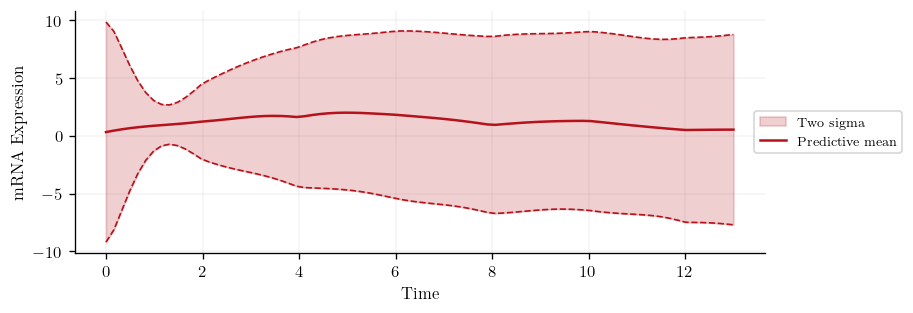

In [168]:
plot_gp(testing_times, predictive_dist3)

In [169]:
# Load kxx, kxf, kff from .npy files
kxx_torch = np.load('trained_kxx.npy')
kxf_torch = np.load('trained_kxf.npy')
kff_torch = np.load('trained_kff.npy')

In [173]:
kxx_torch_inv = np.linalg.inv(kxx_torch)
kfx_kxx_torch = np.matmul(kxf_torch.T, kxx_torch_inv)
mean_func_torch = np.matmul(kfx_kxx_torch, np.asarray(dataset_train.y))

var = kff_torch - np.matmul(kfx_kxx_torch, kxf_torch)
var = np.diag(np.diag(var))
var += np.eye(var.shape[0]) * 1e-3

mean_tensor = torch.tensor(mean_func_torch)
var_tensor = torch.tensor(var)

import gpytorch

mvn = gpytorch.distributions.MultivariateNormal(mean_tensor.squeeze(-1), var_tensor)

In [199]:
var2 = cola.ops.Dense(jnp.array(var))
mvn_gpjax = GaussianDistribution(jnp.atleast_1d(mean_func_torch.squeeze()), var2)

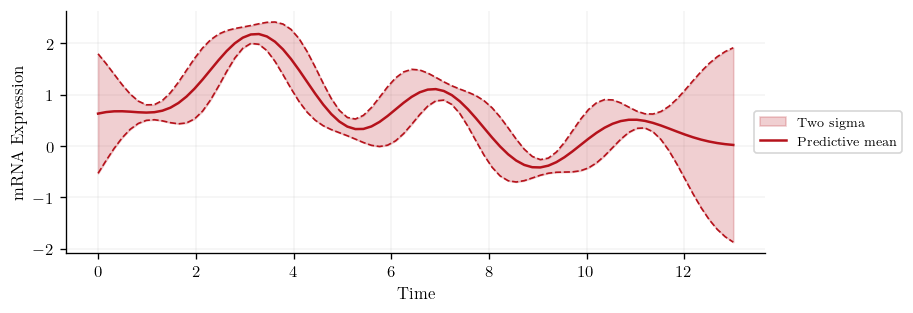

In [201]:
pred_gpjax = optimised_posterior.likelihood(mvn_gpjax)
plot_gp(testing_times, pred_gpjax)

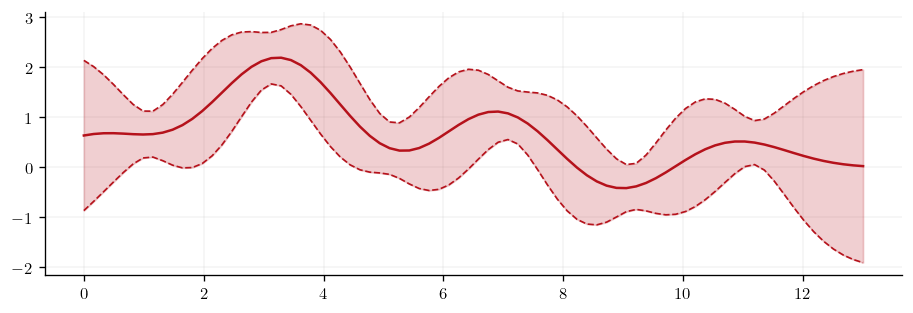

In [183]:
torch_mean = mvn.mean.detach()
torch_std = mvn.variance.sqrt().detach()

# Plot the GP
fig, ax = plt.subplots(figsize=(7.5, 2.5))

ax.fill_between(
    testing_times[:,0].squeeze(),
    torch_mean - 2 * torch_std,
    torch_mean + 2 * torch_std,
    alpha=0.2,
    label="Two sigma",
    color=colors[1],
)
ax.plot(
    testing_times[:,0],
    torch_mean - 2 * torch_std,
    linestyle="--",
    linewidth=1,
    color=colors[1],
)
ax.plot(
    testing_times[:,0],
    torch_mean + 2 * torch_std,
    linestyle="--",
    linewidth=1,
    color=colors[1],
)

ax.plot(testing_times[:,0], torch_mean, label="Predictive mean", color=colors[1])

In [106]:
kxx_inv = jnp.linalg.inv(final_kxx)
kfx_kxx = jnp.matmul(final_kxf.T, kxx_inv)
mean_func = jnp.matmul(kfx_kxx, dataset_train.y)

var = final_kff - jnp.matmul(kfx_kxx, final_kxf)
var = jnp.diag(jnp.diag(var))
var += jnp.eye(var.shape[0]) * 1e-3

In [109]:
mean_func.shape, var.shape

((80, 1), (80, 80))

In [108]:
import gpytorch

# convert to tensors
mean_tensor = torch.tensor(np.asarray(mean_func))
var_tensor = torch.tensor(np.asarray(var))

mvn = gpytorch.distributions.MultivariateNormal(mean_tensor.squeeze(-1), var_tensor)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).

In [115]:
def is_pos_def(x):
    return jnp.all(jnp.linalg.eigvals(x) > 0)


print(is_pos_def(final_kxx))
#print(is_pos_def(final_kxf))
print(is_pos_def(final_kff))


True
True


In [54]:
jnp.diag(variances.reshape(-1))

Array([[0.00303819, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01856116, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0701199 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.10808126, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03522394,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.03665315]], dtype=float64)

In [18]:
outa_box_rbf = gpx.kernels.RBF()
outa_box_rbf_l = outa_box_rbf.replace(lengthscale = 1.25089093)
rbf_gpjax = outa_box_rbf.replace_trainable(variance=False)


In [19]:
x_test = jnp.linspace(0,13,80).reshape(-1,1)
x_test.shape

(80, 1)

In [20]:
kff_test = outa_box_rbf.gram(x_test).to_dense()

In [26]:
jnp.linalg.cholesky(kff_test)

Array([[nan,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan,  0.,  0.],
       [nan, nan, nan, ..., nan, nan,  0.],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float64)

In [25]:
jnp.linalg.eigvals(kff_test) >= 0

Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
       False, False, False, False,  True,  True, False, False],      dtype=bool)

In [22]:
latent3.covariance()

NameError: name 'latent3' is not defined

In [ ]:
cov_mat_dense = cov_mat.to_dense()

In [98]:
jnp.eye(cov_mat_dense.shape[0]) * 1e-3

Array([[0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.001, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.001, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.001]], dtype=float64)